# Hotdog & not-hotdog

The following notebook contains the initial data analysis of the first project.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print(
        "The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator"
    )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


## First step; can we access the data?

In [3]:
train_dir = '/dtu/datasets1/02514/hotdog_nothotdog/train'
test_dir = '/dtu/datasets1/02514/hotdog_nothotdog/test'

Define batch size and transformations:

In [4]:
batch_size = 64

# Mean and std. for ImageNet
standardize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
standardize_inv = transforms.Compose([
    transforms.Normalize([0, 0, 0],
                         [1 / 0.229, 1 / 0.224, 1 / 0.225]),
    transforms.Normalize([-0.485, -0.456, -0.406],
                         [1, 1, 1])
])

transform_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64), antialias=True),  # They are not all square
])
transform_train = transforms.Compose(
    [transform_base, 
     standardize,
     transforms.RandomRotation(10)])
transform_test = transforms.Compose([transform_base, standardize])

Create datasets

In [5]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

Create dataloaders

In [6]:
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=8)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=8)

It actually worked. Let us try to plot a few of the images:

In [19]:
def imshow(img):
    img = standardize_inv(img)
    npimg = img.numpy()
    fig, ax = plt.subplots(dpi=100)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


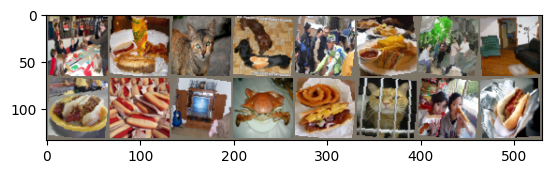

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
grid = utils.make_grid(images[:16])
imshow(grid)

Seems like we have a few hotdogs, and a lot of not-hotdogs

# Let us build a simple CNN to get started

In [9]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Input dimension, max_pool halves the size. Hence 64/2= 32, 32/2 = 16
        self.ff_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 7),  # We have 7 categories
            nn.Softmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.ff_layers(x)
        return x

In [10]:
model = CNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [12]:
# From exercises:
def train(model, optimizer, num_epochs=10):

    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target)

    out_dict = {
        'train_acc': [],
        'test_acc': [],
        'train_loss': [],
        'test_loss': []
    }

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader),
                                                 total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target == predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target == predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct / len(train_dataset))
        out_dict['test_acc'].append(test_correct / len(test_dataset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(
            f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
            f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%"
        )
    return out_dict

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 1.841	 test: 1.156	 Accuracy train: 48.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.669	 test: 0.696	 Accuracy train: 63.3%	 test: 67.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.590	 test: 0.608	 Accuracy train: 70.7%	 test: 71.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.552	 test: 0.648	 Accuracy train: 74.5%	 test: 66.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.546	 test: 0.626	 Accuracy train: 75.1%	 test: 69.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.543	 test: 0.656	 Accuracy train: 74.4%	 test: 68.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.538	 test: 0.661	 Accuracy train: 75.7%	 test: 65.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.536	 test: 0.621	 Accuracy train: 74.6%	 test: 69.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.531	 test: 0.625	 Accuracy train: 75.1%	 test: 71.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.511	 test: 0.583	 Accuracy train: 75.5%	 test: 73.2%


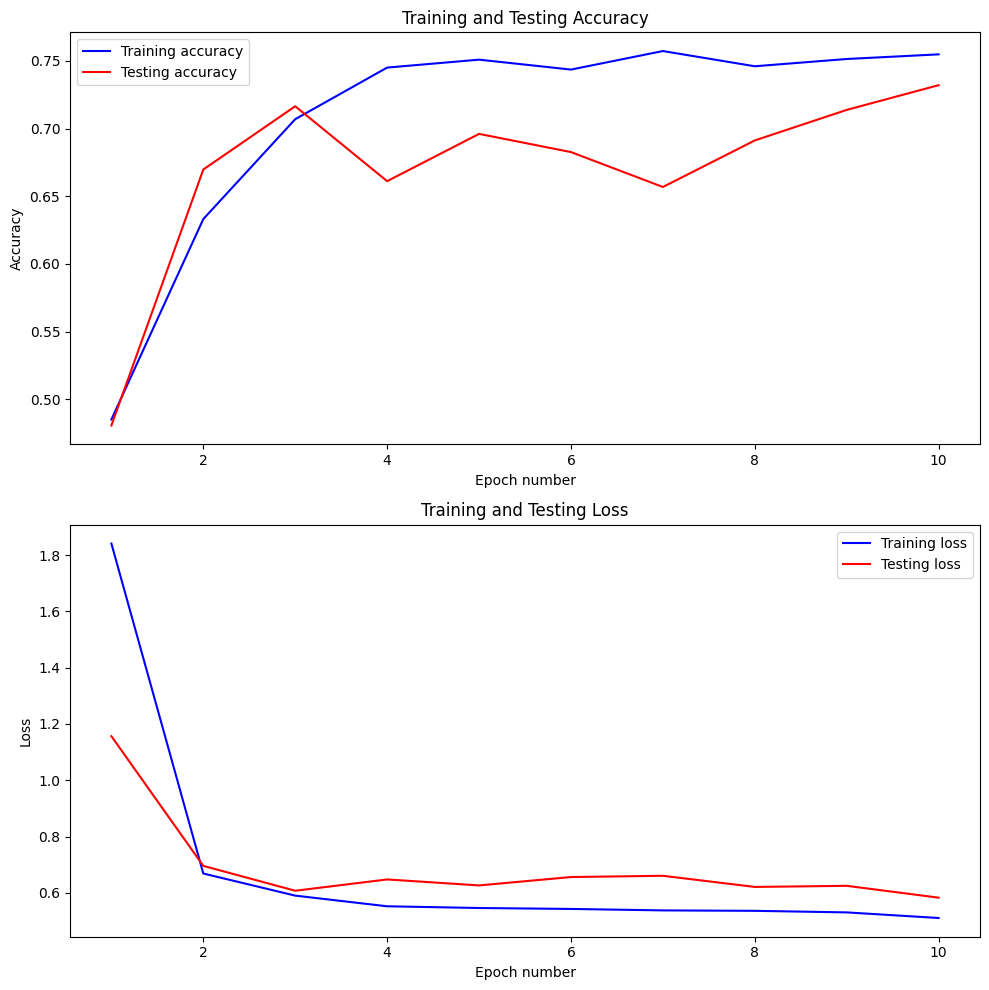

In [13]:
model.apply(reset_weights)
out_dict = train(model, optimizer)

# Get training and testing data
train_accuracy = out_dict['train_acc']
test_accuracy = out_dict['test_acc']
train_loss = out_dict['train_loss']
test_loss = out_dict['test_loss']

# Number of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plotting accuracy
ax1.plot(epochs, train_accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, test_accuracy, 'r', label='Testing accuracy')
ax1.set_title('Training and Testing Accuracy')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plotting loss
ax2.plot(epochs, train_loss, 'b', label='Training loss')
ax2.plot(epochs, test_loss, 'r', label='Testing loss')
ax2.set_title('Training and Testing Loss')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

Let us just quickly try and compare Adam and SGD:

In [14]:
# Define the model
model = CNN()
model.to(device)

# Reset the weights
model.apply(reset_weights)

# Now train with SGD and Adam
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.1)
output_sgd = train(model, optimizer_sgd)

# Reset the weights before training with Adam
model.apply(reset_weights)
optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)
output_adam = train(model, optimizer_adam)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 50.4%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: nan	 test: nan	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 2.037	 test: 0.964	 Accuracy train: 47.6%	 test: 49.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.632	 test: 0.713	 Accuracy train: 64.3%	 test: 69.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.591	 test: 0.720	 Accuracy train: 70.1%	 test: 66.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.571	 test: 0.750	 Accuracy train: 72.7%	 test: 68.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.537	 test: 0.630	 Accuracy train: 74.8%	 test: 68.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.530	 test: 0.630	 Accuracy train: 75.0%	 test: 68.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.529	 test: 0.608	 Accuracy train: 75.3%	 test: 71.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.508	 test: 0.582	 Accuracy train: 75.7%	 test: 70.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.506	 test: 0.590	 Accuracy train: 76.1%	 test: 71.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.499	 test: 0.616	 Accuracy train: 77.0%	 test: 69.3%


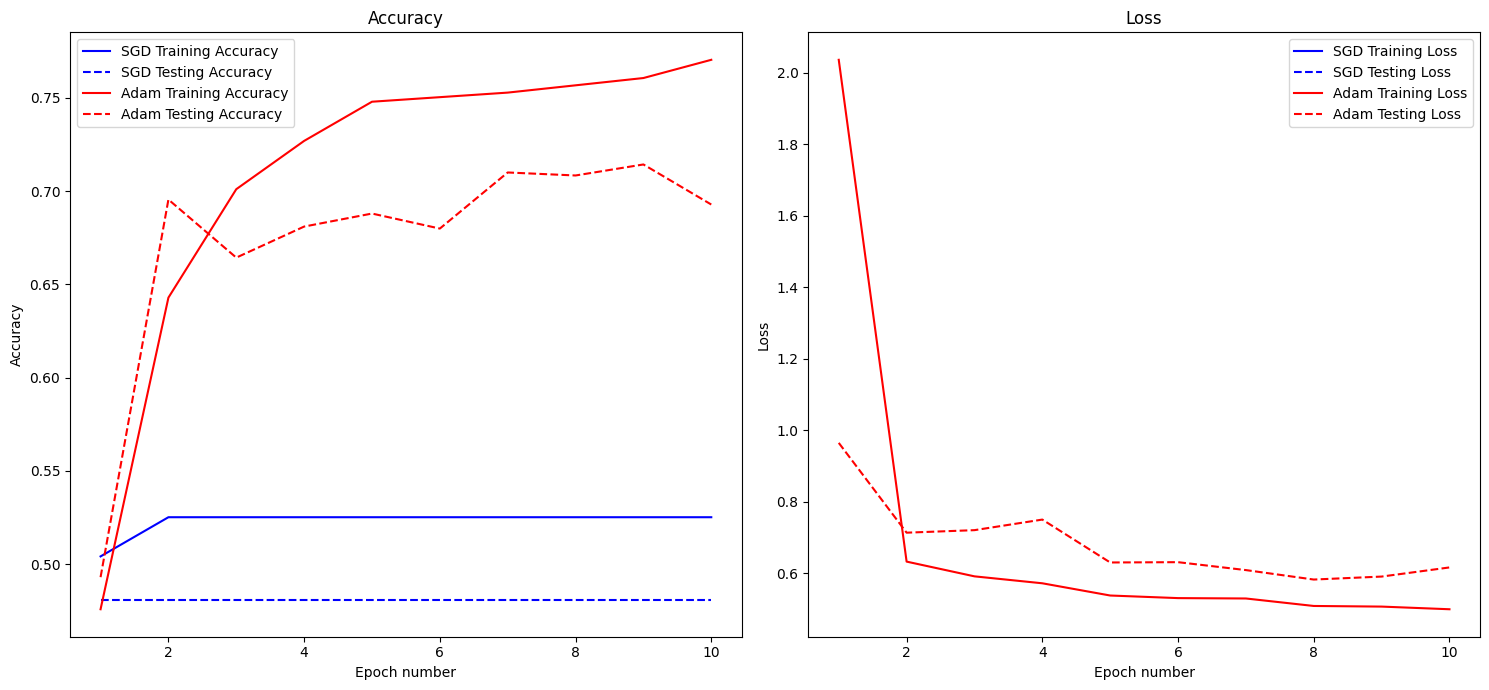

In [15]:
# Get training and testing data
epochs = range(1, len(output_sgd['train_acc']) + 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Accuracy
axs[0].plot(epochs, output_sgd['train_acc'], 'b', label='SGD Training Accuracy')
axs[0].plot(epochs, output_sgd['test_acc'], 'b--', label='SGD Testing Accuracy')
axs[0].plot(epochs,
            output_adam['train_acc'],
            'r',
            label='Adam Training Accuracy')
axs[0].plot(epochs,
            output_adam['test_acc'],
            'r--',
            label='Adam Testing Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch number')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(epochs, output_sgd['train_loss'], 'b', label='SGD Training Loss')
axs[1].plot(epochs, output_sgd['test_loss'], 'b--', label='SGD Testing Loss')
axs[1].plot(epochs, output_adam['train_loss'], 'r', label='Adam Training Loss')
axs[1].plot(epochs, output_adam['test_loss'], 'r--', label='Adam Testing Loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch number')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

This does not look so good yet, but the model is also really simpel. Let us try to investigate the images that we missclassifiy:

In [20]:
model.eval()
misclassified_images = []
misclassified_labels = []
predicted_labels = []
for images, labels in test_loader:
    # Move to GPU
    images, labels = images.to(device), labels.to(device)
    # Forward pass and determine predictions
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Find misclassifications
    wrong_preds = (preds != labels)
    misclassified_images.append(images[wrong_preds])
    misclassified_labels.append(labels[wrong_preds])
    predicted_labels.append(preds[wrong_preds])

Actual label: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       device='cuda:0') - Predicted label:tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       device='cuda:0')


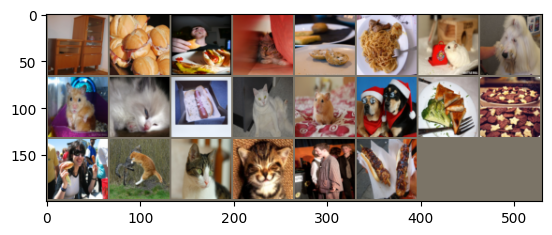

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       device='cuda:0') - Predicted label:tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       device='cuda:0')


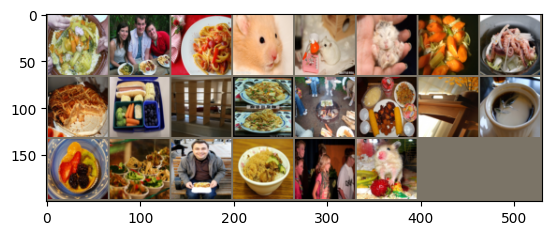

Actual label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0') - Predicted label:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')


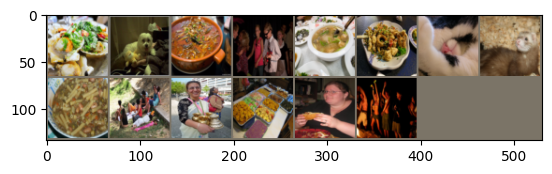

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0') - Predicted label:tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       device='cuda:0')


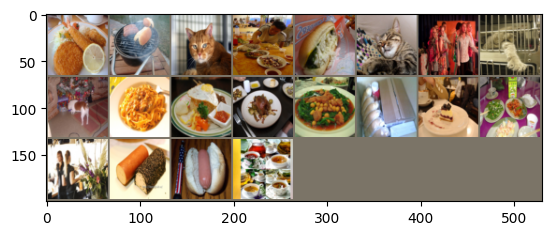

Actual label: tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       device='cuda:0') - Predicted label:tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       device='cuda:0')


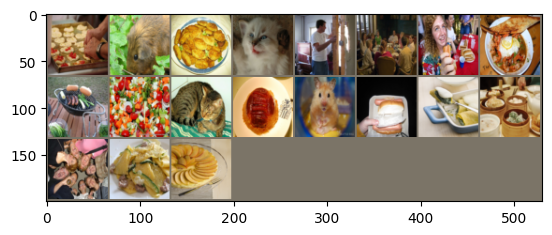

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') - Predicted label:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


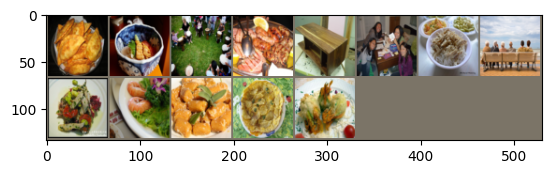

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0') - Predicted label:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       device='cuda:0')


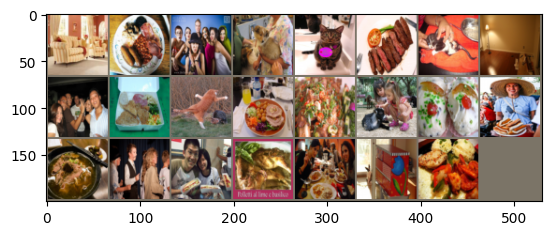

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       device='cuda:0') - Predicted label:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       device='cuda:0')


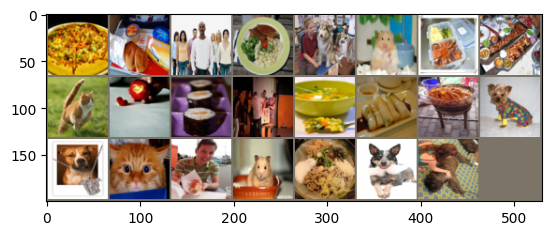

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') - Predicted label:tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


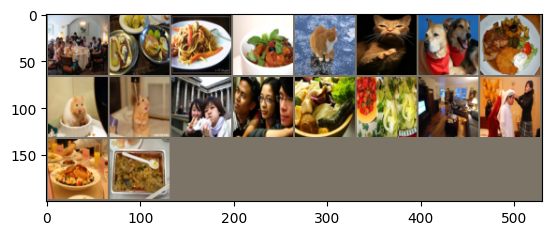

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0') - Predicted label:tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')


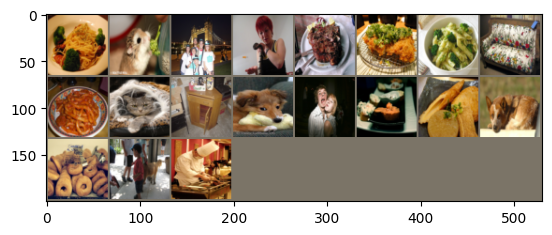

In [21]:
for i in range(10):
    print(
        f"Actual label: {misclassified_labels[i]} - Predicted label:{predicted_labels[i]}"
    )
    imshow(utils.make_grid(misclassified_images[i].cpu()))